In [1]:
import torch #Main PyTorch library for tensor computation and GPU support
import torch.nn as nn # Provides neural network layers and building blocks
import torch.nn.functional as F #Provides neural network layers and building blocks
import torch.optim as optim #Provides optimization algorithms like SGD, Adam, etc.
from torch.utils.data import DataLoader #Utility to batch, shuffle, and load data in parallel.
import torchvision #Popular computer vision library with datasets and models.
import torchvision.transforms as transforms #Used for preprocessing like normalization or converting images to tensors.
from torchsummary import summary
# !pip install torchviz
from torchviz import make_dot
from IPython.display import Image
# !pip install graphviz
from graphviz import Digraph


import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')
import random


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# =====================================
# 1. IMPORT EVERYTHING & DATA SETUP
# =====================================

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and prepare datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

#Creates an iterable for training data in batches of 64.
#Shuffling the data helps prevent overfitting and ensures better training.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print("")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 60000
Test samples: 10000


In [3]:
# =====================================
# 2. NEURAL NETWORK MODEL
# =====================================
#Mnist image is 28X28 1channel-grayscale

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #1-input channel, produce 32 output channel, kernel 3x3, stride of 1, no padding 28x28->26x26
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  #64 filters on the 32 feature map from conv1 by 3x3 kernel 26x26->24x24
        self.dropout1 = nn.Dropout2d(0.25) #Applies dropout (randomly zeroing out channels) with probability 25% after pooling. Helps prevent overfitting.
        self.dropout2 = nn.Dropout2d(0.5) #A second dropout layer (50%) applied before the final output layer.
        self.fc1 = nn.Linear(9216, 128) #Fully connected layer: input features = 9216, output = 128. 24x24 → 12x12 64*12*12=9216
        self.fc2 = nn.Linear(128, 10) #Final layer: maps the 128 features to 10 output classes (digits 0–9).

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [4]:
# =====================================
# 3. QUANTIZATION FUNCTIONS
# =====================================

def quantize_weights_int8(weights):
    """
    Quantize weights to 8-bit integers (1 byte per weight)
    input take weight which are float32

    """
    # Find min and max values
    w_min = weights.min()
    w_max = weights.max()

    # Calculate scale and zero point
    scale = (w_max - w_min) / 255.0
    zero_point = torch.round(-w_min / scale).clamp(0, 255) #ensures that the mapping preserves the original values.

    # Quantize
    quantized = torch.round(weights / scale + zero_point).clamp(0, 255)

    # Store quantization parameters
    return quantized.to(torch.uint8), scale, zero_point

def dequantize_weights_int8(quantized_weights, scale, zero_point):
    """
    Convert quantized weights back to float32
    """
    return scale * (quantized_weights.float() - zero_point)

def quantize_model_weights(model):
    """Fixed quantization function that properly handles all parameters"""
    from copy import deepcopy
    quantized_model = deepcopy(model).to(device)
    quant_params = {}

    with torch.no_grad():
        for name, param in quantized_model.named_parameters():
            if param.requires_grad:  # Only quantize trainable parameters
                data = param.data
                max_abs = torch.max(torch.abs(data)).item()
                scale = max_abs / 127.0 if max_abs > 0 else 1.0

                quant_params[name] = scale
                quantized = torch.round(data / scale).clamp(-128, 127).to(torch.int8)

                # 🔥 Ensure _quantized is attached to ALL parameters
                param._quantized = quantized.clone()

                # Set dequantized weights back
                param.data.copy_(quantized.to(torch.float32) * scale)
                
                print(f"[DEBUG] Quantized {name}: shape={param.shape}, scale={scale:.6f}")

    return quantized_model, quant_params


In [5]:
# =====================================
# 4. TRAINING FUNCTION
# =====================================

def train_model(model, train_loader, epochs=5):
    """Train the model"""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001) #Uses the Adam optimizer to update model weights.

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad() #Resets gradients from the previous batch.
            output = model(data) #Performs a forward pass to get predictions.
            loss = F.nll_loss(output, target) #Computes negative log-likelihood loss between predicted log-probabilities and ground truth.
            loss.backward() #Backpropagates the loss to compute gradients
            optimizer.step() #Updates model weights based on gradients.
            total_loss += loss.item()

            if batch_idx % 300 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.6f}')

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1} completed. Average Loss: {avg_loss:.6f}')

In [6]:
# =====================================
# 5. TEST BENCH FUNCTION
# =====================================

def test_model(model, test_loader, model_name="Model"):
    """Test the model and return accuracy"""
    model.eval() #Disables layers like dropout and batch norm from updating.
    #Ensures consistent behavior during testing.
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): #Prevents PyTorch from computing gradients
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Computes total negative log-likelihood loss over the batch (using sum for aggregation).
            # Accumulates the total test loss across all batches.
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= total
    accuracy = 100. * correct / total

    print(f'{model_name} - Test Loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)')
    return accuracy, test_loss

In [7]:
# =====================================
# 6. WEIGHT MODIFICATION FUNCTIONS
# =====================================

import torch
import torch.nn as nn
import numpy as np
from copy import deepcopy
import struct

def count_model_weights(model):
    """
    Count and display the number of weights in each layer and total
    """
    print("=" * 80)
    print("MODEL WEIGHT STATISTICS")
    print("=" * 80)

    total_weights = 0
    layer_stats = {}

    for name, param in model.named_parameters():
        if 'weight' in name:
            layer_weights = param.numel()
            total_weights += layer_weights
            layer_stats[name] = {
                'count': layer_weights,
                'shape': param.shape,
                'size_mb': layer_weights * 4 / (1024 * 1024)  # FP32 = 4 bytes
            }

            print(f"Layer: {name}")
            print(f"  Shape: {param.shape}")
            print(f"  Weights: {layer_weights:,}")
            print(f"  Memory (FP32): {layer_weights * 4 / 1024:.2f} KB")
            print()

    total_size_mb = total_weights * 4 / (1024 * 1024)
    print(f"TOTAL WEIGHTS: {total_weights:,}")
    print(f"TOTAL MEMORY (FP32): {total_size_mb:.2f} MB")
    print(f"TOTAL MEMORY (INT8): {total_size_mb/4:.2f} MB")
    print("=" * 80)

    return total_weights, layer_stats

def flip_random_bit_in_float32(value):
    """
    Flip a random bit in a float32 value
    Returns the modified value
    """
    # Convert float to bytes
    packed = struct.pack('f', value)
    bytes_array = bytearray(packed)

    # Choose random byte (0-3) and random bit (0-7)
    byte_idx = np.random.randint(0, 4)
    bit_idx = np.random.randint(0, 8)

    # Flip the bit using XOR
    bytes_array[byte_idx] ^= (1 << bit_idx)

    # Convert back to float
    modified_value = struct.unpack('f', bytes_array)[0]

    return modified_value

def flip_random_bit_in_int8(value, scale, zero_point):
    """
    Flip a random bit in an 8-bit quantized value
    Returns the modified quantized value and corresponding float
    """
    # Ensure value is in valid range
    quantized_val = int(np.clip(value, 0, 255))

    # Choose random bit (0-7) to flip
    bit_idx = np.random.randint(0, 8)

    # Flip the bit
    modified_quantized = quantized_val ^ (1 << bit_idx)
    modified_quantized = np.clip(modified_quantized, 0, 255)  # Keep in valid range

    # Convert back to float
    modified_float = scale * (modified_quantized - zero_point)

    return modified_quantized, modified_float

def modify_weights_bit_flip(model, flip_probability=1e-3, quantized=False, quant_params=None):
    """
    Modify weights by flipping random bits with given probability

    Args:
        model: PyTorch model
        flip_probability: Probability of flipping a bit in each weight (default 10^-3)
        quantized: If True, work with quantized weights
        quant_params: Quantization parameters if working with quantized weights
    """
    print("=" * 80)
    print(f"BIT-FLIP MODIFICATION (Probability: {flip_probability:.0e})")
    print("=" * 80)

    modified_model = deepcopy(model)
    total_weights = 0
    total_flips = 0
    layer_flip_stats = {}

    for name, param in modified_model.named_parameters():
        if 'weight' in name:
            layer_weights = param.numel()
            total_weights += layer_weights
            layer_flips = 0

            # Get original weights
            weights = param.data.clone()

            if quantized and quant_params and name in quant_params:
                # Work with quantized weights
                qparams = quant_params[name]
                scale = qparams['scale']
                zero_point = qparams['zero_point']

                # Quantize current weights
                quantized_weights = torch.round(weights / scale + zero_point).clamp(0, 255)

                # Create random mask for bit flips
                flip_mask = torch.rand_like(weights) < flip_probability
                flip_indices = torch.nonzero(flip_mask, as_tuple=False)

                print(f"Layer {name}: Checking {layer_weights:,} weights...")

                for idx_tensor in flip_indices:
                    idx = tuple(idx_tensor.tolist())
                    original_quant = int(quantized_weights[idx].item())

                    # Flip random bit in quantized value
                    modified_quant, modified_float = flip_random_bit_in_int8(
                        original_quant, scale, zero_point
                    )

                    # Update the weight
                    weights[idx] = modified_float
                    layer_flips += 1

            else:
                # Work with float32 weights
                weights_flat = weights.flatten()

                # Create random mask for bit flips
                flip_mask = torch.rand(weights_flat.size()) < flip_probability
                flip_indices = torch.nonzero(flip_mask, as_tuple=False).flatten()

                print(f"Layer {name}: Checking {layer_weights:,} weights...")

                for flat_idx in flip_indices:
                    original_val = weights_flat[flat_idx].item()
                    modified_val = flip_random_bit_in_float32(original_val)
                    weights_flat[flat_idx] = modified_val
                    layer_flips += 1

                # Reshape back to original shape
                weights = weights_flat.reshape(param.data.shape)

            # Update parameter
            param.data = weights
            total_flips += layer_flips

            layer_flip_stats[name] = {
                'total_weights': layer_weights,
                'flips': layer_flips,
                'flip_rate': layer_flips / layer_weights if layer_weights > 0 else 0
            }

            print(f"  Flipped {layer_flips} bits out of {layer_weights:,} weights ({layer_flips/layer_weights*100:.4f}%)")

    print(f"\nTOTAL SUMMARY:")
    print(f"  Total weights: {total_weights:,}")
    print(f"  Expected flips: {total_weights * flip_probability:.1f}")
    print(f"  Actual flips: {total_flips}")
    print(f"  Actual flip rate: {total_flips/total_weights:.2e}")
    print("=" * 80)

    return modified_model, layer_flip_stats

def compare_weights_before_after(original_model, modified_model, layer_name, num_samples=5):
    """
    Compare weights before and after bit flipping
    """
    print("=" * 80)
    print(f"WEIGHT COMPARISON: {layer_name}")
    print("=" * 80)

    orig_param = None
    mod_param = None

    # Find the specified layer
    for name, param in original_model.named_parameters():
        if layer_name in name and 'weight' in name:
            orig_param = param
            break

    for name, param in modified_model.named_parameters():
        if layer_name in name and 'weight' in name:
            mod_param = param
            break

    if orig_param is None or mod_param is None:
        print(f"Layer {layer_name} not found!")
        return

    # Find changed weights
    diff_mask = ~torch.isclose(orig_param.data, mod_param.data, rtol=1e-6)
    changed_indices = torch.nonzero(diff_mask, as_tuple=False)

    print(f"Found {len(changed_indices)} changed weights out of {orig_param.numel()}")

    # Show some examples
    num_to_show = min(num_samples, len(changed_indices))
    if num_to_show > 0:
        print(f"\nShowing first {num_to_show} changed weights:")

        for i in range(num_to_show):
            idx = tuple(changed_indices[i].tolist())
            orig_val = orig_param.data[idx].item()
            mod_val = mod_param.data[idx].item()

            print(f"\nWeight #{i+1} at position {idx}:")
            print(f"  Original: {orig_val:.8f}")
            print(f"  Modified: {mod_val:.8f}")
            print(f"  Difference: {abs(orig_val - mod_val):.8e}")

            # Show bit representation
            orig_bytes = struct.pack('f', orig_val)
            mod_bytes = struct.pack('f', mod_val)

            print(f"  Original bytes: {[f'0x{b:02x}' for b in orig_bytes]}")
            print(f"  Modified bytes: {[f'0x{b:02x}' for b in mod_bytes]}")

            # Find which bit was flipped
            for byte_idx in range(4):
                if orig_bytes[byte_idx] != mod_bytes[byte_idx]:
                    orig_byte = orig_bytes[byte_idx]
                    mod_byte = mod_bytes[byte_idx]
                    xor_result = orig_byte ^ mod_byte
                    bit_pos = int(np.log2(xor_result)) if xor_result > 0 else -1
                    print(f"  Flipped bit {bit_pos} in byte {byte_idx}")
    else:
        print("No weights were modified!")

# Example usage function
def demonstrate_bit_flip_modification(model, quant_params=None):
    """
    Demonstrate the bit flip modification process
    """
    print("DEMONSTRATION: Bit-Flip Weight Modification")
    print("=" * 60)

    # Count weights first
    total_weights, layer_stats = count_model_weights(model)

    # Calculate expected number of flips
    flip_prob = 1e-3
    expected_flips = total_weights * flip_prob
    print(f"\nWith flip probability {flip_prob:.0e}:")
    print(f"Expected number of bit flips: {expected_flips:.1f}")

    # Perform bit flip modification
    modified_model, flip_stats = modify_weights_bit_flip(
        model, flip_probability=flip_prob, quantized=False
    )

    # Compare first layer
    first_layer = list(layer_stats.keys())[0].replace('.weight', '')
    compare_weights_before_after(model, modified_model, first_layer, 3)

    return modified_model, flip_stats

In [8]:
# =====================================
# 7. ANALYSIS AND PLOTTING FUNCTIONS
# =====================================

def analyze_weight_distribution(model, title="Weight Distribution"):
    """Analyze and plot weight distributions"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(title)

    layer_idx = 0
    for name, param in model.named_parameters():
        if 'weight' in name and layer_idx < 4:
            weights = param.data.cpu().numpy().flatten()
            ax = axes[layer_idx // 2, layer_idx % 2]
            ax.hist(weights, bins=50, alpha=0.7)
            ax.set_title(f'{name}')
            ax.set_xlabel('Weight Value')
            ax.set_ylabel('Frequency')
            layer_idx += 1

    plt.tight_layout()
    plt.show()

def plot_accuracy_comparison(results):
    """Plot accuracy comparison"""
    models = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'][:len(models)])
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 100)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def calculate_memory_usage(model, quantized_params=None):
    """Calculate memory usage of the model"""
    total_params = 0
    fp32_size = 0
    int8_size = 0

    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        fp32_size += param_count * 4  # 4 bytes per float32

        if quantized_params and name in quantized_params:
            int8_size += param_count * 1  # 1 byte per int8
        else:
            int8_size += param_count * 4  # Keep as float32 if not quantized

    print(f"Total parameters: {total_params:,}")
    print(f"FP32 model size: {fp32_size / 1024:.2f} KB")
    print(f"INT8 model size: {int8_size / 1024:.2f} KB")
    print(f"Compression ratio: {fp32_size / int8_size:.2f}x")

    return total_params, fp32_size, int8_size

MNIST 8-bit Weight Quantization Analysis

1. Training Original Model...


Epoch 1/3, Batch 0, Loss: 2.338300
Epoch 1/3, Batch 300, Loss: 0.140722
Epoch 1/3, Batch 600, Loss: 0.208453
Epoch 1/3, Batch 900, Loss: 0.078555
Epoch 1 completed. Average Loss: 0.222230
Epoch 2/3, Batch 0, Loss: 0.124283
Epoch 2/3, Batch 300, Loss: 0.068508
Epoch 2/3, Batch 600, Loss: 0.153864
Epoch 2/3, Batch 900, Loss: 0.205949
Epoch 2 completed. Average Loss: 0.091450
Epoch 3/3, Batch 0, Loss: 0.147269
Epoch 3/3, Batch 300, Loss: 0.053397
Epoch 3/3, Batch 600, Loss: 0.034708
Epoch 3/3, Batch 900, Loss: 0.027853
Epoch 3 completed. Average Loss: 0.073997
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
         Dropout2d-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
         Dropout2d-5                  [-1, 128]    

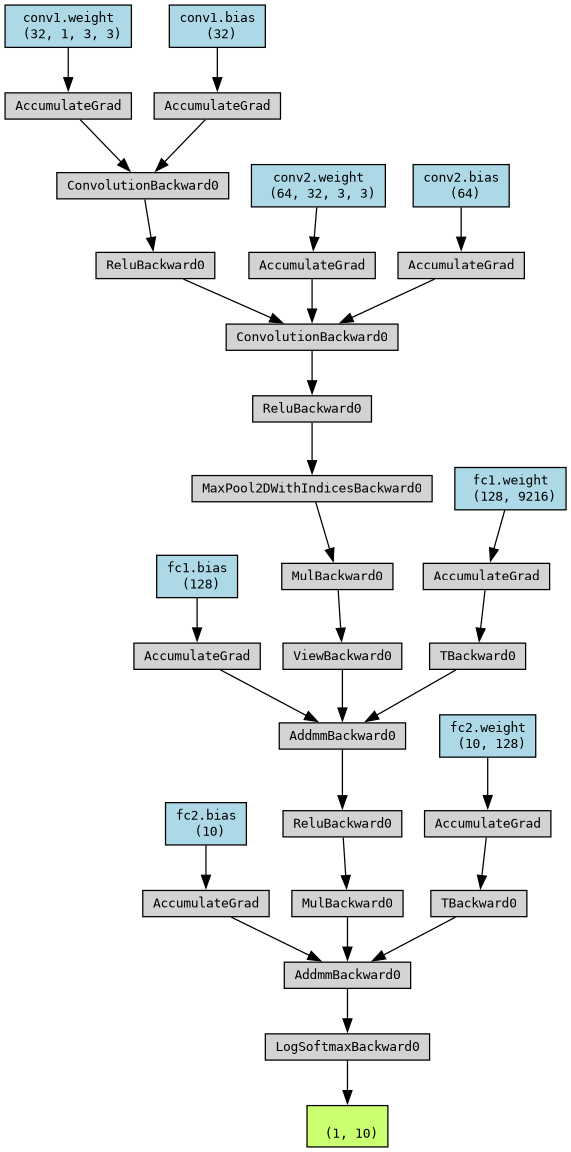


2. Testing Original Model...
Original FP32 - Test Loss: 0.0325, Accuracy: 9888/10000 (98.88%)

3. Quantizing Model Weights to 8-bit...
[DEBUG] Quantized conv1.weight: shape=torch.Size([32, 1, 3, 3]), scale=0.004543
[DEBUG] Quantized conv1.bias: shape=torch.Size([32]), scale=0.002277
[DEBUG] Quantized conv2.weight: shape=torch.Size([64, 32, 3, 3]), scale=0.002949
[DEBUG] Quantized conv2.bias: shape=torch.Size([64]), scale=0.000505
[DEBUG] Quantized fc1.weight: shape=torch.Size([128, 9216]), scale=0.002383
[DEBUG] Quantized fc1.bias: shape=torch.Size([128]), scale=0.000801
[DEBUG] Quantized fc2.weight: shape=torch.Size([10, 128]), scale=0.002026
[DEBUG] Quantized fc2.bias: shape=torch.Size([10]), scale=0.001306
Quantized INT8 - Test Loss: 0.0326, Accuracy: 9891/10000 (98.91%)

4. Memory Usage Analysis...
Total parameters: 1,199,882
FP32 model size: 4687.04 KB
INT8 model size: 1171.76 KB
Compression ratio: 4.00x

5. Analyzing Weight Distributions...


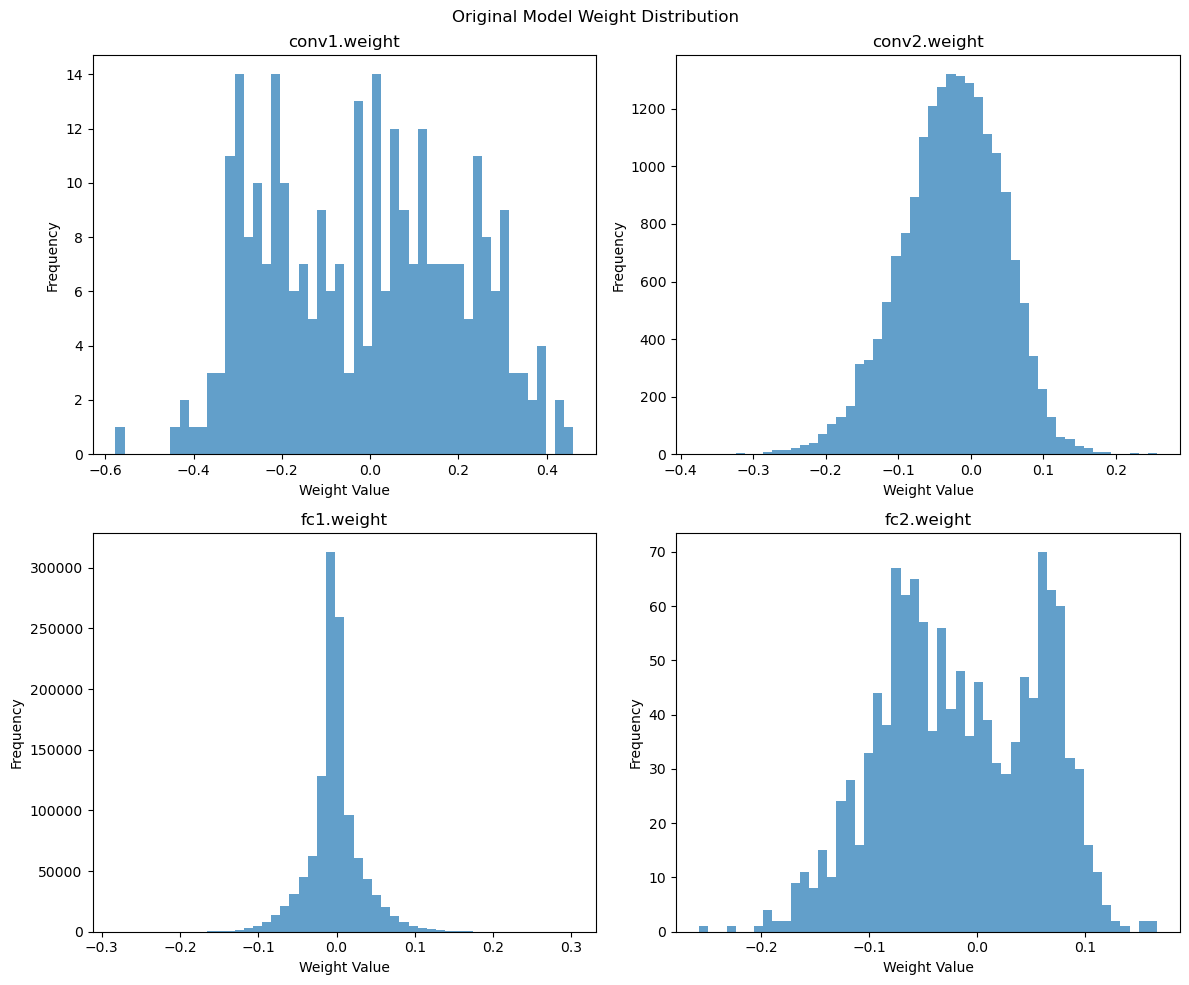

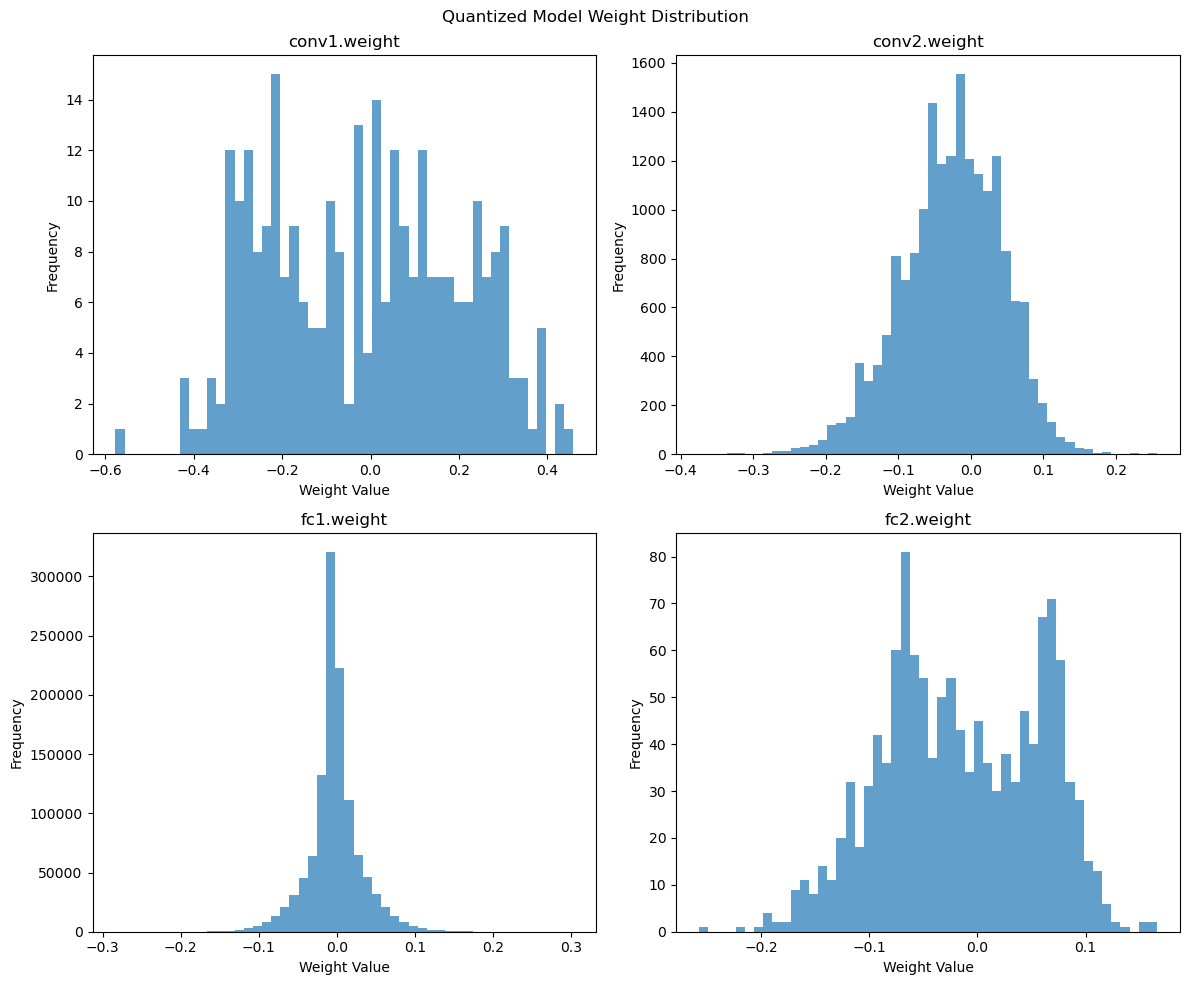

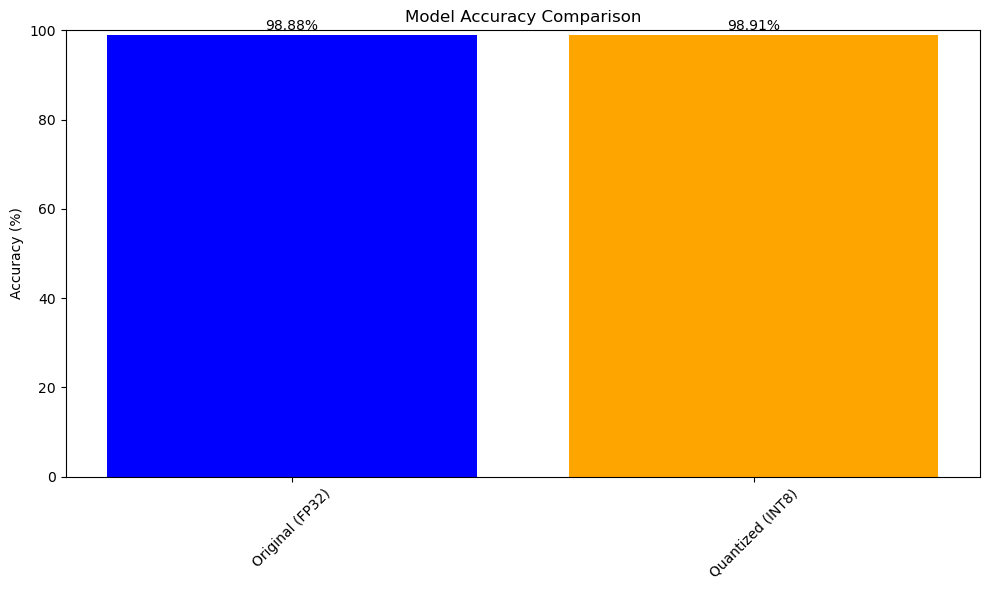


SETUP COMPLETE!
Ready for weight modifications!
Use the following functions to modify weights:
- modify_weights_percentage(model, percentage, layer_name)
- modify_specific_weights(model, weight_indices, new_values, layer_name)
- test_model(modified_model, test_loader, 'Modified Model')
- plot_accuracy_comparison(results)


In [9]:
# =====================================
# 8. MAIN EXECUTION PIPELINE
# =====================================

def main():
    print("=" * 60)
    print("MNIST 8-bit Weight Quantization Analysis")
    print("=" * 60)

    # Initialize and train the original model
    print("\n1. Training Original Model...")
    original_model = MNISTNet().to(device)
    train_model(original_model, train_loader, epochs=3)

    # Create model and display summary
    summary(original_model, input_size=(1, 28, 28))

    x = torch.randn(1, 1, 28, 28).to(device)  # Simulated MNIST input
    y = original_model(x)

    make_dot(y, params=dict(original_model.named_parameters())).render("mnist_net", format="png")
    display(Image(filename="mnist_net.png"))  # ✅ show in notebook


    # Test original model
    print("\n2. Testing Original Model...")
    original_accuracy, original_loss = test_model(original_model, test_loader, "Original FP32")

    # Quantize model weights
    print("\n3. Quantizing Model Weights to 8-bit...")
    quantized_model, quant_params = quantize_model_weights(original_model)
    quantized_accuracy, quantized_loss = test_model(quantized_model, test_loader, "Quantized INT8")

    # Calculate memory usage
    print("\n4. Memory Usage Analysis...")
    calculate_memory_usage(original_model, quant_params)

    # Store results for comparison
    results = {
        'Original (FP32)': {'accuracy': original_accuracy, 'loss': original_loss},
        'Quantized (INT8)': {'accuracy': quantized_accuracy, 'loss': quantized_loss}
    }

    # Analyze weight distributions
    print("\n5. Analyzing Weight Distributions...")
    analyze_weight_distribution(original_model, "Original Model Weight Distribution")
    analyze_weight_distribution(quantized_model, "Quantized Model Weight Distribution")

    # Plot initial comparison
    plot_accuracy_comparison(results)

    print("\n" + "=" * 60)
    print("SETUP COMPLETE!")
    print("=" * 60)
    print("Ready for weight modifications!")
    print("Use the following functions to modify weights:")
    print("- modify_weights_percentage(model, percentage, layer_name)")
    print("- modify_specific_weights(model, weight_indices, new_values, layer_name)")
    print("- test_model(modified_model, test_loader, 'Modified Model')")
    print("- plot_accuracy_comparison(results)")

    return original_model, quantized_model, quant_params, results

# Run the main pipeline
if __name__ == "__main__":
    original_model, quantized_model, quant_params, results = main()

MNIST Weight Degradation Sensitivity (Bigger Perturbations)

1. Initializing Original Model...

--- Model Parameter Count ---
conv1.weight   :      288 parameters (shape: [32, 1, 3, 3])
conv1.bias     :       32 parameters (shape: [32])
conv2.weight   :   18,432 parameters (shape: [64, 32, 3, 3])
conv2.bias     :       64 parameters (shape: [64])
fc1.weight     : 1,179,648 parameters (shape: [128, 9216])
fc1.bias       :      128 parameters (shape: [128])
fc2.weight     :    1,280 parameters (shape: [10, 128])
fc2.bias       :       10 parameters (shape: [10])
Total          : 1,199,882 parameters
Trainable      : 1,199,882 parameters

2. Quantizing Model Weights to 8-bit...
[DEBUG] Quantized conv1.weight: shape=torch.Size([32, 1, 3, 3]), scale=0.004543
[DEBUG] Quantized conv1.bias: shape=torch.Size([32]), scale=0.002277
[DEBUG] Quantized conv2.weight: shape=torch.Size([64, 32, 3, 3]), scale=0.002949
[DEBUG] Quantized conv2.bias: shape=torch.Size([64]), scale=0.000505
[DEBUG] Quantized

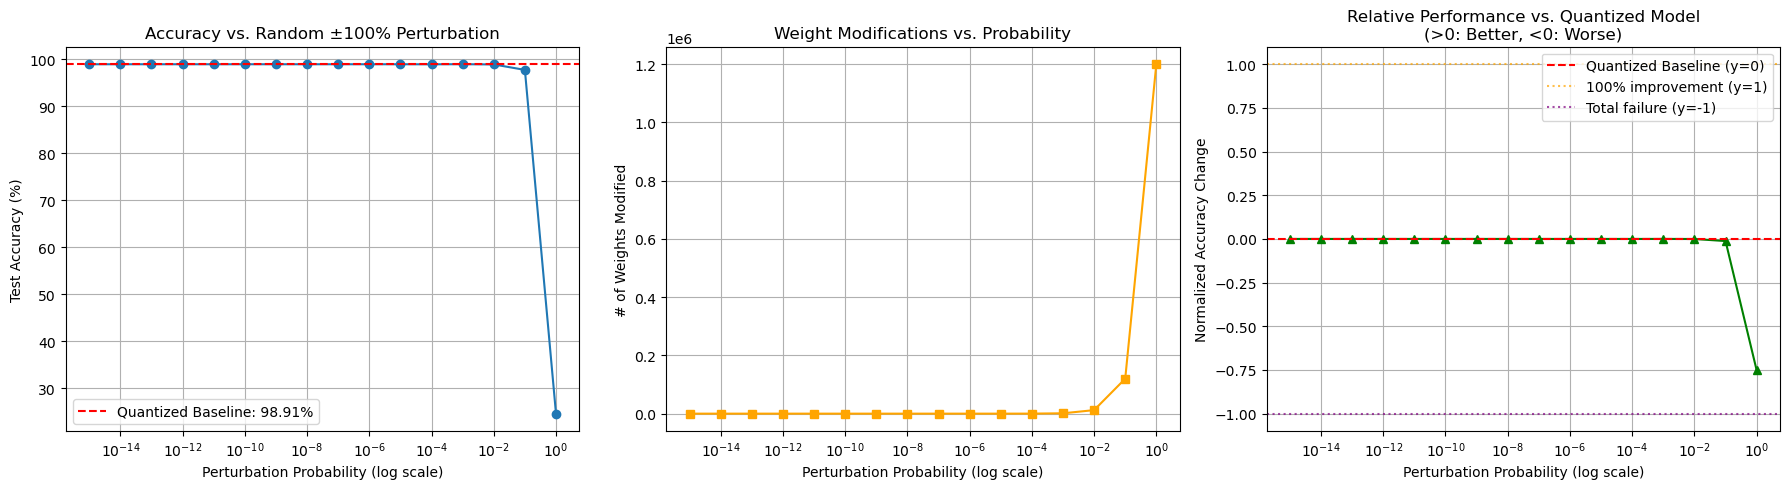


[GRAPHS SAVED]
✓ Combined graph: weight_perturbation_analysis_combined.png
✓ Accuracy graph: accuracy_vs_perturbation.png
✓ Weight modifications: weight_modifications_vs_probability.png
✓ Normalized performance: normalized_performance_vs_perturbation.png

--- Enhanced Summary with Bigger Perturbations ---
Total model parameters: 1,199,882
Perturbation: ±100% of weight value (minimum ±10)
Tested 16 probability values from 1.0 to 10^-15
 Probability  Changed Percentage   Accuracy
--------------------------------------------------
    1.00e+00 1,199,882  100.0000%     24.56%
    1.00e-01  119,933    9.9954%     97.71%
    1.00e-02   12,125    1.0105%     98.87%
    1.00e-03    1,206    0.1005%     98.92%
    1.00e-04      109    0.0091%     98.90%
    1.00e-05       13    0.0011%     98.91%
    1.00e-06        3    0.0003%     98.91%
    1.00e-07        0    0.0000%     98.91%
    1.00e-08        0    0.0000%     98.91%
    1.00e-09        0    0.0000%     98.91%
    1.00e-10        0   

In [10]:
# =====================================
# BIT-FLIP FUNCTIONS
# =====================================
def apply_random_weight_perturbation(original_model, p: float, quant_params):
    """
    Fixed version that uses original model and ensures proper perturbation
    """
    from copy import deepcopy
    import numpy as np

    # Create fresh copy from original model
    perturbed_model = deepcopy(original_model).to(device)
    total_changed = 0
    total_weights = 0
    
    # Track missed weights
    missed_weights_not_in_quant_params = []
    missed_weights_no_quantized = []

    with torch.no_grad():
        for name, param in perturbed_model.named_parameters():
            if name not in quant_params:
                missed_weights_not_in_quant_params.append(name)
                continue
                
            # Get the original quantized values
            original_param = dict(original_model.named_parameters())[name]
            if not hasattr(original_param, "_quantized"):
                missed_weights_no_quantized.append(name)
                continue

            q = original_param._quantized.cpu().numpy()
            flat_q = q.flatten()
            total_weights += len(flat_q)

            # Apply perturbation
            mask = np.random.rand(flat_q.shape[0]) < p
            directions = np.random.choice([-1, 1], size=flat_q.shape[0])
            
            # # Calculate perturbation (100% of current value, minimum 10 for much bigger change)
            # perturbation = np.where(
            #     flat_q == 0,
            #     directions * 10,  # If weight is 0, perturb by ±10 (much bigger change)
            #     np.round(1.0 * flat_q * directions).astype(np.int8)  # 100% instead of 50%
            # )
            perturbation = np.where(
            flat_q == 0,
            directions * 20,  # Increased from ±10 to ±20 for zero weights
            np.round(2.0 * flat_q * directions).astype(np.int8)  # Changed from 1.0 to 2.0 for ±200%
            )       
            
            # Ensure minimum perturbation of ±10 when mask is True (much bigger minimum)
            perturbation = np.where((mask) & (np.abs(perturbation) < 10), 
                                  directions * 10, perturbation)

            new_flat = flat_q + (mask * perturbation)
            new_flat = np.clip(new_flat, -128, 127)

            changed = np.sum(flat_q != new_flat)
            total_changed += changed
            
            # Convert back to float and update parameter
            scale = quant_params[name]
            float_weights = (new_flat.astype(np.float32) * scale).reshape(q.shape)
            param.data.copy_(torch.tensor(float_weights, dtype=torch.float32, device=device))
            
            # Also update the _quantized field for consistency
            param._quantized = torch.tensor(new_flat.reshape(q.shape), dtype=torch.int8)

    # Print comprehensive summary of missed weights
    print(f"\n[MISSED WEIGHTS SUMMARY]")
    print(f"Total weights processed: {total_weights}")
    print(f"Total changed: {total_changed}/{total_weights} weights ({100*total_changed/total_weights:.4f}%)")
    
    if missed_weights_not_in_quant_params:
        print(f"\nWeights NOT in quant_params ({len(missed_weights_not_in_quant_params)} layers):")
        for name in missed_weights_not_in_quant_params:
            param = dict(original_model.named_parameters())[name]
            print(f"  - {name}: {param.numel():,} parameters (shape: {list(param.shape)})")
    
    if missed_weights_no_quantized:
        print(f"\nWeights with NO _quantized field ({len(missed_weights_no_quantized)} layers):")
        for name in missed_weights_no_quantized:
            param = dict(original_model.named_parameters())[name]
            print(f"  - {name}: {param.numel():,} parameters (shape: {list(param.shape)})")
    
    if not missed_weights_not_in_quant_params and not missed_weights_no_quantized:
        print("✓ All weights were successfully processed!")

    return perturbed_model, total_changed



def sweep_random_perturbation_effects(original_quantized_model, test_loader, quant_params):
    """Fixed sweep function that uses original model as baseline"""
    probabilities = [10**(-i) for i in range(0, 16)]
    accuracies = []
    num_changed_list = []

    print("\n--- Sweeping ±100% Weight Perturbation Probabilities ---")
    print(f"Testing {len(probabilities)} probability values from 1.0 to 10^-15")
    
    # Write to log file
    with open('log.txt', 'a') as f:
        f.write("\n--- Sweeping ±100% Weight Perturbation Probabilities ---\n")
        f.write(f"Testing {len(probabilities)} probability values from 1.0 to 10^-15\n")
    
    # Test original model first
    print("\nTesting original quantized model:")
    original_acc, _ = test_model(original_quantized_model, test_loader, "Original Quantized")
    
    for i, p in enumerate(probabilities):
        print(f"\n--- Testing p={p:.2e} ({i+1}/{len(probabilities)}) ---")
        # Write to log file
        with open('log.txt', 'a') as f:
            f.write(f"\n--- Testing p={p:.2e} ({i+1}/{len(probabilities)}) ---\n")
        
        perturbed_model, num_changed = apply_random_weight_perturbation(
            original_quantized_model, p, quant_params
        )
        acc, _ = test_model(perturbed_model, test_loader, model_name=f"Perturb p={p:.2e}")
        accuracies.append(acc)
        num_changed_list.append(num_changed)

    # Calculate normalized accuracy relative to quantized baseline
    normalized_accuracies = [(acc - original_acc) / original_acc for acc in accuracies]

    # Updated 3 graphs layout
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.semilogx(probabilities, accuracies, marker='o')
    plt.axhline(y=original_acc, color='r', linestyle='--', label=f'Quantized Baseline: {original_acc:.2f}%')
    plt.xlabel("Perturbation Probability (log scale)")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Accuracy vs. Random ±100% Perturbation")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.semilogx(probabilities, num_changed_list, marker='s', color='orange')
    plt.xlabel("Perturbation Probability (log scale)")
    plt.ylabel("# of Weights Modified")
    plt.title("Weight Modifications vs. Probability")
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.semilogx(probabilities, normalized_accuracies, marker='^', color='green')
    plt.axhline(y=0, color='r', linestyle='--', label='Quantized Baseline (y=0)')
    plt.axhline(y=1, color='orange', linestyle=':', alpha=0.7, label='100% improvement (y=1)')
    plt.axhline(y=-1, color='purple', linestyle=':', alpha=0.7, label='Total failure (y=-1)')
    plt.xlabel("Perturbation Probability (log scale)")
    plt.ylabel("Normalized Accuracy Change")
    plt.title("Relative Performance vs. Quantized Model\n(>0: Better, <0: Worse)")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('weight_perturbation_analysis_combined.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save individual graphs
    # Graph 1: Accuracy vs Perturbation
    plt.figure(figsize=(8, 6))
    plt.semilogx(probabilities, accuracies, marker='o', linewidth=2, markersize=6)
    plt.axhline(y=original_acc, color='r', linestyle='--', linewidth=2, label=f'Quantized Baseline: {original_acc:.2f}%')
    plt.xlabel("Perturbation Probability (log scale)", fontsize=12)
    plt.ylabel("Test Accuracy (%)", fontsize=12)
    plt.title("Accuracy vs. Random ±100% Perturbation", fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.7)
    plt.tight_layout()
    plt.savefig('accuracy_vs_perturbation.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Graph 2: Weight Modifications
    plt.figure(figsize=(8, 6))
    plt.semilogx(probabilities, num_changed_list, marker='s', color='orange', linewidth=2, markersize=6)
    plt.xlabel("Perturbation Probability (log scale)", fontsize=12)
    plt.ylabel("# of Weights Modified", fontsize=12)
    plt.title("Weight Modifications vs. Probability", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.7)
    plt.tight_layout()
    plt.savefig('weight_modifications_vs_probability.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Graph 3: Normalized Performance
    plt.figure(figsize=(8, 6))
    plt.semilogx(probabilities, normalized_accuracies, marker='^', color='green', linewidth=2, markersize=6)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Quantized Baseline (y=0)')
    plt.axhline(y=1, color='orange', linestyle=':', alpha=0.7, linewidth=2, label='100% improvement (y=1)')
    plt.axhline(y=-1, color='purple', linestyle=':', alpha=0.7, linewidth=2, label='Total failure (y=-1)')
    plt.xlabel("Perturbation Probability (log scale)", fontsize=12)
    plt.ylabel("Normalized Accuracy Change", fontsize=12)
    plt.title("Relative Performance vs. Quantized Model", fontsize=14, fontweight='bold')
    plt.figtext(0.5, 0.02, ">0: Better than baseline, <0: Worse than baseline", ha='center', fontsize=10, style='italic')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.7)
    plt.tight_layout()
    plt.savefig('normalized_performance_vs_perturbation.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"\n[GRAPHS SAVED]")
    print(f"✓ Combined graph: weight_perturbation_analysis_combined.png")
    print(f"✓ Accuracy graph: accuracy_vs_perturbation.png")
    print(f"✓ Weight modifications: weight_modifications_vs_probability.png")
    print(f"✓ Normalized performance: normalized_performance_vs_perturbation.png")
    
    return accuracies, num_changed_list

def count_total_parameters(model):
    """Count total parameters in the model"""
    total_params = 0
    trainable_params = 0
    
    print("\n--- Model Parameter Count ---")
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        if param.requires_grad:
            trainable_params += param_count
        print(f"{name:15s}: {param_count:8,d} parameters (shape: {list(param.shape)})")
    
    print(f"{'Total':15s}: {total_params:8,d} parameters")
    print(f"{'Trainable':15s}: {trainable_params:8,d} parameters")
    return total_params, trainable_params


    
def main():
    print("=" * 60)
    print("MNIST Weight Degradation Sensitivity (Bigger Perturbations)")
    print("=" * 60)

    print("\n1. Initializing Original Model...")
    # Count total parameters
    total_params, trainable_params = count_total_parameters(original_model)
    
    print("\n2. Quantizing Model Weights to 8-bit...")
    # Write to log file
    with open('log.txt', 'w') as f:  # 'w' to overwrite existing file
        f.write("2. Quantizing Model Weights to 8-bit...\n")
    
    quantized_model, quant_params = quantize_model_weights(original_model)

    print("\n3. Testing Quantized Model Without Perturbation")
    test_model(quantized_model, test_loader, model_name="Quantized No Perturbation")

    print("\n4. Sweeping Weight Perturbation Probabilities (Extended Range)")
    accuracies, num_changed = sweep_random_perturbation_effects(
        quantized_model, test_loader, quant_params
    )
    
    print("\n--- Enhanced Summary with Bigger Perturbations ---")
    probabilities = [10**(-i) for i in range(0, 16)]
    print(f"Total model parameters: {total_params:,}")
    print(f"Perturbation: ±100% of weight value (minimum ±10)")
    print(f"Tested {len(probabilities)} probability values from 1.0 to 10^-15")
    print(f"{'Probability':>12s} {'Changed':>8s} {'Percentage':>10s} {'Accuracy':>10s}")
    print("-" * 50)
    
    # Show all results since we're back to 16 values
    for i in range(len(probabilities)):
        p, acc, changed = probabilities[i], accuracies[i], num_changed[i]
        percentage = (changed / total_params) * 100
        print(f"{p:>12.2e} {changed:>8,d} {percentage:>9.4f}% {acc:>9.2f}%")


if __name__ == "__main__":
    main()

In [11]:

def extract_signed_j_msb(array: np.ndarray, j: int) -> np.ndarray:
    """
    Extracts top-j MSBs from signed int8 array using bitwise AND mask.
    Keeps top-j bits in position, zeroes the rest, and returns signed int8.
    Prints every step for debugging.
    """
    assert array.dtype == np.int8, "Input array must be int8"
    assert 1 <= j <= 8, "j must be between 1 and 8"

    results = []

    for val in array:
        # print(f"\n1. Input value: {val}")
        unsigned_val = np.uint8(val)
        # print(f"2. Binary: {format(unsigned_val, '08b')}")
        # print(f"3. j = {j}")

        # 4. Create mask with top-j bits set
        mask = ((1 << j) - 1) << (8 - j)
        # print(f"4. Mask:         {format(mask, '08b')}")

        # 5. Apply AND between bits only
        masked = unsigned_val & mask
        # print(f"5. After AND:    {format(masked, '08b')}")

        # 6. Convert back to signed int8
        signed_result = np.int8(masked)
        # print(f"6. Returned value: {signed_result} (binary: {format(masked, '08b')})")

        results.append(signed_result)

    return np.array(results, dtype=np.int8)



def extract_signed_j_msb_median(array: np.ndarray, j: int) -> np.ndarray:
    """
    Extracts top-j MSBs from signed int8 array using bitwise AND mask.
    Keeps top-j bits in position, zeroes the rest, and returns signed int8.
    Prints every step for debugging.
    """
    assert array.dtype == np.int8, "Input array must be int8"
    assert 1 <= j <= 8, "j must be between 1 and 8"

    results = []

    for val in array:
        # print(f"\n1. Input value: {val}")
        unsigned_val = np.uint8(val)
        # print(f"2. Binary: {format(unsigned_val, '08b')}")
        # print(f"3. j = {j}")

        # 4. Create mask with top-j bits set
        mask = ((1 << j) - 1) << (8 - j)
        # print(f"4. Mask:         {format(mask, '08b')}")

        # 5. Apply AND between bits only
        masked = unsigned_val & mask
        # print(f"5. After AND:    {format(masked, '08b')}")

        if j < 8:
            median_bit_pos = 8 - j - 1
            masked |= (1 << median_bit_pos)
            # print(f"5.5  Returned value: {masked} (binary: {format(masked, '08b')})")

        # 6. Convert back to signed int8
        signed_result = np.int8(masked)
        # print(f"6. Returned value: {signed_result} (binary: {format(masked, '08b')})")

        results.append(signed_result)

    return np.array(results, dtype=np.int8)



def apply_msb_weight_perturbation(original_model, quant_params, j, msb_function):
    """
    Applies perturbation to each weight using a user-supplied MSB transformation function.
    """
    from copy import deepcopy
    import numpy as np

    perturbed_model = deepcopy(original_model).to(device)
    total_changed = 0
    total_weights = 0
    missed_weights_not_in_quant_params = []
    missed_weights_no_quantized = []

    with torch.no_grad():
        for name, param in perturbed_model.named_parameters():
            if name not in quant_params:
                missed_weights_not_in_quant_params.append(name)
                continue

            original_param = dict(original_model.named_parameters())[name]
            if not hasattr(original_param, "_quantized"):
                missed_weights_no_quantized.append(name)
                continue

            q = original_param._quantized.cpu().numpy().astype(np.int8)
            flat_q = q.flatten()
            total_weights += len(flat_q)

            # Apply chosen MSB perturbation function
            new_flat = msb_function(flat_q, j)
            new_flat = np.clip(new_flat, -128, 127)

            changed = np.sum(flat_q != new_flat)
            total_changed += changed

            # Update model weights
            scale = quant_params[name]
            float_weights = (new_flat.astype(np.float32) * scale).reshape(q.shape)
            param.data.copy_(torch.tensor(float_weights, dtype=torch.float32, device=device))
            param._quantized = torch.tensor(new_flat.reshape(q.shape), dtype=torch.int8)

    print(f"\n[MISSED WEIGHTS SUMMARY]")
    print(f"Total weights processed: {total_weights}")
    print(f"Total changed: {total_changed}/{total_weights} weights ({100 * total_changed / total_weights:.4f}%)")
    return perturbed_model, total_changed


In [12]:
import os
def plot_weight_histograms(original_model, quant_params, msb_function, output_dir="weight_histograms", int8_mode=False):
    """
    For each j=1..8, apply MSB truncation and plot histogram of the quantized weight values.
    Supports plotting in int8 or uint8 domain depending on `int8_mode`.

    Args:
        original_model: trained model with ._quantized attributes
        quant_params: scale factors per parameter
        msb_function: function to apply MSB truncation
        output_dir: directory to store histogram images
        int8_mode: if True, plot using signed int8 values (-128 to 127),
                   else use uint8 values (0 to 255)
    """
    os.makedirs(output_dir, exist_ok=True)

    # Collect all original weights
    original_weights = []
    for name, param in original_model.named_parameters():
        if hasattr(param, "_quantized"):
            q = param._quantized.cpu().numpy()
            q = q.astype(np.int8) if int8_mode else q.astype(np.uint8)
            original_weights.extend(q.flatten())
    original_weights = np.array(original_weights)

    # Plot original histogram
    plt.figure(figsize=(8, 4))
    hist_range = (-128, 127) if int8_mode else (0, 255)
    plt.hist(original_weights, bins=256, range=hist_range, color='gray')
    plt.title("Original Quantized Weights Distribution")
    plt.xlabel("Int8 Value" if int8_mode else "Unsigned 8-bit Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "hist_j0_original.png"))
    plt.close()

    # For j = 1 to 8, show MSB-truncated histogram
    for j in range(1, 9):
        int8_weights = original_weights.astype(np.int8)
        truncated_weights = msb_function(int8_weights, j)

        if not int8_mode:
            truncated_weights = np.clip(truncated_weights, 0, 255).astype(np.uint8)

        plt.figure(figsize=(8, 4))
        plt.hist(truncated_weights, bins=256, range=hist_range, color='blue', alpha=0.7)
        plt.title(f"Truncated Weights Histogram (j={j} MSBs Preserved)")
        plt.xlabel("Int8 Value" if int8_mode else "Unsigned 8-bit Value")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"hist_j{j}.png"))
        plt.close()

def sweep_msb_levels(original_quantized_model, test_loader, quant_params, msb_function):
    """
    Sweeps j=1 to 8 and applies a given MSB transformation function to perturb the model weights.
    Evaluates the perturbed model accuracy for each level of MSB truncation.

    Args:
        original_quantized_model: the model to perturb (already quantized).
        test_loader: dataloader for evaluation.
        quant_params: scale factors for model parameters.
        msb_function: function that takes (array: np.ndarray, j: int) and returns transformed weights.

    Returns:
        Tuple of (accuracies: List[float], num_changed_list: List[int])
    """
    j_values = range(1, 9)
    accuracies = []
    num_changed_list = []

    print("\nTesting original quantized model:")
    original_acc, _ = test_model(original_quantized_model, test_loader, "Original Quantized")

    for j in j_values:
        print(f"\n--- Testing j={j} MSBs ---")
        perturbed_model, num_changed = apply_msb_weight_perturbation(
            original_quantized_model, quant_params, j, msb_function=msb_function
        )
        acc, _ = test_model(perturbed_model, test_loader, model_name=f"MSB j={j}")
        accuracies.append(acc)
        num_changed_list.append(num_changed)

    normalized_accuracies = [(acc - original_acc) / original_acc for acc in accuracies]

    # Plotting
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(j_values, accuracies, marker='o')
    plt.axhline(y=original_acc, color='r', linestyle='--', label=f'Baseline: {original_acc:.2f}%')
    plt.xlabel("j (Top MSBs Preserved)")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Accuracy vs. MSB Level")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(j_values, num_changed_list, marker='s', color='orange')
    plt.xlabel("j (Top MSBs Preserved)")
    plt.ylabel("# of Weights Modified")
    plt.title("Weight Changes vs. MSB Level")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(j_values, normalized_accuracies, marker='^', color='green')
    plt.axhline(y=0, color='r', linestyle='--', label='Baseline (y=0)')
    plt.xlabel("j (Top MSBs Preserved)")
    plt.ylabel("Normalized Accuracy Change")
    plt.title("Relative Performance vs. Quantized Model")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('msb_sweep_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    return accuracies, num_changed_list




MSB Sensitivity Sweep on Quantized Model

[1] Initializing Original Model...

--- Model Parameter Count ---
conv1.weight   :      288 parameters (shape: [32, 1, 3, 3])
conv1.bias     :       32 parameters (shape: [32])
conv2.weight   :   18,432 parameters (shape: [64, 32, 3, 3])
conv2.bias     :       64 parameters (shape: [64])
fc1.weight     : 1,179,648 parameters (shape: [128, 9216])
fc1.bias       :      128 parameters (shape: [128])
fc2.weight     :    1,280 parameters (shape: [10, 128])
fc2.bias       :       10 parameters (shape: [10])
Total          : 1,199,882 parameters
Trainable      : 1,199,882 parameters

[2] Quantizing Model Weights to 8-bit...
[DEBUG] Quantized conv1.weight: shape=torch.Size([32, 1, 3, 3]), scale=0.004543
[DEBUG] Quantized conv1.bias: shape=torch.Size([32]), scale=0.002277
[DEBUG] Quantized conv2.weight: shape=torch.Size([64, 32, 3, 3]), scale=0.002949
[DEBUG] Quantized conv2.bias: shape=torch.Size([64]), scale=0.000505
[DEBUG] Quantized fc1.weight: shap

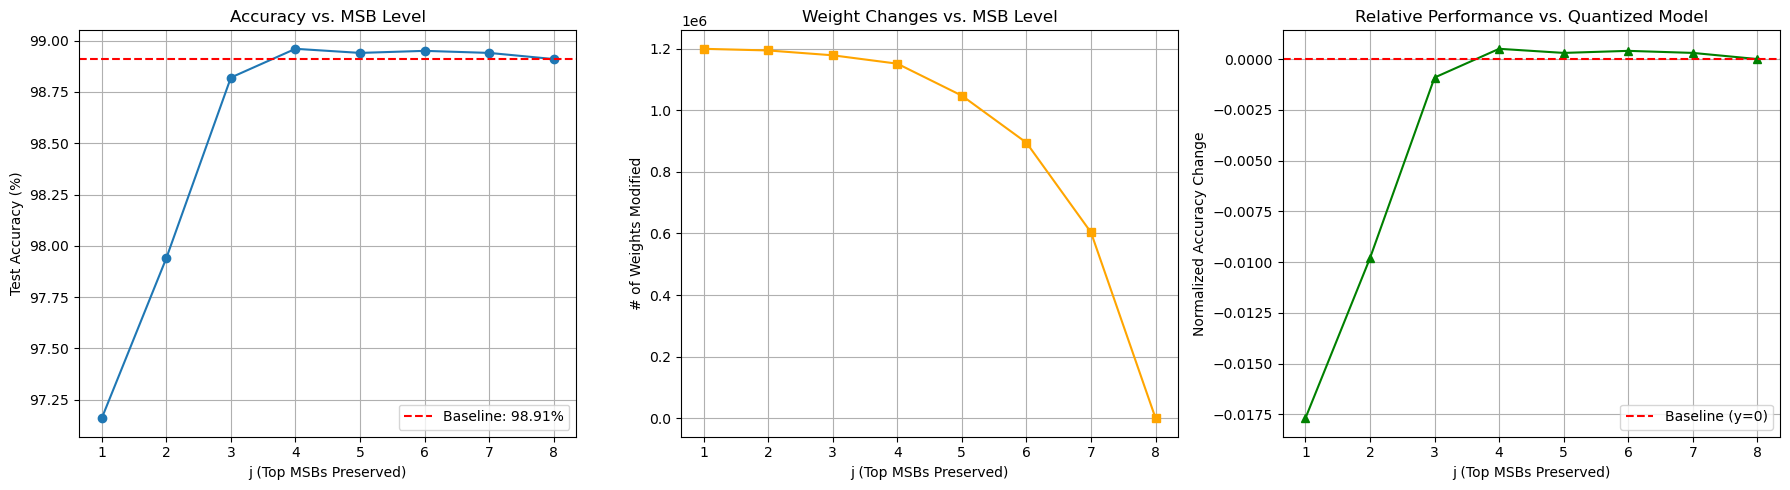


--- Summary for MSB Sweep (median) ---
  j    Changed   %Changed   Accuracy
----------------------------------------
  1  1,199,657     99.98%     97.16%
  2  1,194,275     99.53%     97.94%
  3  1,178,581     98.22%     98.82%
  4  1,151,386     95.96%     98.96%
  5  1,047,551     87.30%     98.94%
  6    894,791     74.57%     98.95%
  7    603,498     50.30%     98.94%
  8          0      0.00%     98.91%

[4-regular] Sweeping MSB Levels using 'regular' function

Testing original quantized model:
Original Quantized - Test Loss: 0.0326, Accuracy: 9891/10000 (98.91%)

--- Testing j=1 MSBs ---

[MISSED WEIGHTS SUMMARY]
Total weights processed: 1199882
Total changed: 1129435/1199882 weights (94.1288%)
MSB j=1 - Test Loss: 2.3035, Accuracy: 1135/10000 (11.35%)

--- Testing j=2 MSBs ---

[MISSED WEIGHTS SUMMARY]
Total weights processed: 1199882
Total changed: 1129210/1199882 weights (94.1101%)
MSB j=2 - Test Loss: 2.3026, Accuracy: 1135/10000 (11.35%)

--- Testing j=3 MSBs ---

[MISSED 

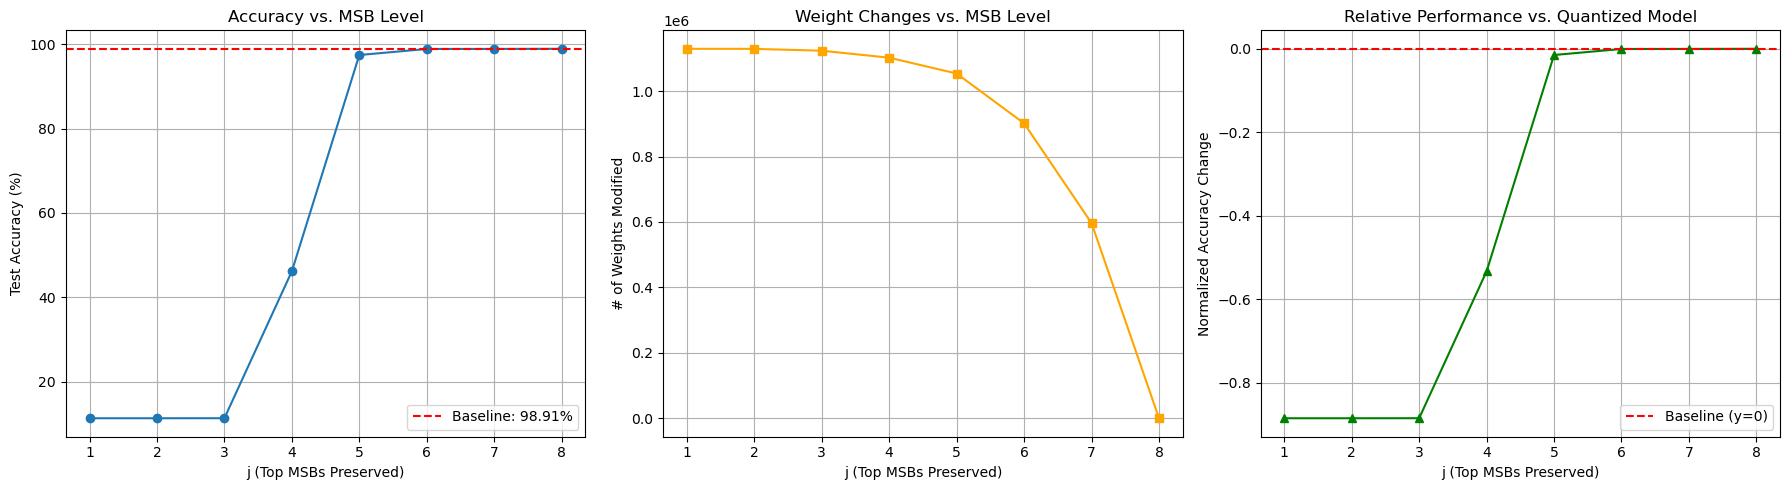


--- Summary for MSB Sweep (regular) ---
  j    Changed   %Changed   Accuracy
----------------------------------------
  1  1,129,435     94.13%     11.35%
  2  1,129,210     94.11%     11.35%
  3  1,123,603     93.64%     11.36%
  4  1,102,302     91.87%     46.18%
  5  1,053,806     87.83%     97.44%
  6    901,475     75.13%     98.87%
  7    596,384     49.70%     98.88%
  8          0      0.00%     98.91%


In [13]:
def main():
    print("=" * 60)
    print("MSB Sensitivity Sweep on Quantized Model")
    print("=" * 60)

    # 1. Load and inspect model
    print("\n[1] Initializing Original Model...")
    total_params, _ = count_total_parameters(original_model)

    # 2. Quantize weights
    print("\n[2] Quantizing Model Weights to 8-bit...")
    with open('log.txt', 'w') as f:
        f.write("Quantizing Model Weights to 8-bit...\n")
    quantized_model, quant_params = quantize_model_weights(original_model)

    # 3. Test quantized model without any perturbation
    print("\n[3] Testing Quantized Model Without Perturbation")
    test_model(quantized_model, test_loader, model_name="Quantized No Perturbation")

    # Define MSB functions to test
    msb_functions = {
        "median": extract_signed_j_msb_median,
        "regular": extract_signed_j_msb
    }

    for label, msb_function in msb_functions.items():
        print(f"\n[4-{label}] Sweeping MSB Levels using '{label}' function")
        accuracies, num_changed = sweep_msb_levels(
            quantized_model,
            test_loader,
            quant_params,
            msb_function=msb_function
        )

        # 5. Print summary
        print(f"\n--- Summary for MSB Sweep ({label}) ---")
        print(f"{'j':>3s} {'Changed':>10s} {'%Changed':>10s} {'Accuracy':>10s}")
        print("-" * 40)
        for j, acc, changed in zip(range(1, 9), accuracies, num_changed):
            pct = (changed / total_params) * 100
            print(f"{j:>3d} {changed:>10,d} {pct:>9.2f}% {acc:>9.2f}%")

        # 6. Plot histograms for each strategy
        output_dir = f"weight_histograms_{label}"
        plot_weight_histograms(
            quantized_model,
            quant_params,
            msb_function=msb_function,
            output_dir=output_dir,
            int8_mode=True
        )


if __name__ == "__main__":
    main()  

In [14]:
def extract_half_signed_j_msb(array: np.ndarray, j: int, half: str) -> np.ndarray:
    """
    Extracts top-j MSBs from either upper or lower 4-bit half of signed int8 array.
    Keeps j bits in their original position, zeroes out the rest. Other half is zeroed.
    """
    assert array.dtype == np.int8, "Input array must be int8"
    assert 0 <= j <= 4, "j must be between 0 and 4"
    assert half in ['upper', 'lower'], "half must be 'upper' or 'lower'"

    results = []
    for val in array:
        uval = np.uint8(val)
        if half == 'upper':
            upper = (uval >> 4) & 0x0F
            mask = ((1 << j) - 1) << (4 - j) if j > 0 else 0
            new_upper = upper & mask
            combined = (new_upper << 4)
        else:  # lower
            lower = uval & 0x0F
            mask = ((1 << j) - 1) << (4 - j) if j > 0 else 0
            new_lower = lower & mask
            combined = new_lower
        results.append(np.int8(combined))
    return np.array(results, dtype=np.int8)

def extract_half_signed_j_msb_median(array: np.ndarray, j: int, half: str) -> np.ndarray:
    """
    Like extract_half_signed_j_msb but ensures the (4-j-1)th bit is set for magnitude retention if j < 4.
    """
    assert array.dtype == np.int8, "Input array must be int8"
    assert 0 <= j <= 4, "j must be between 0 and 4"
    assert half in ['upper', 'lower'], "half must be 'upper' or 'lower'"

    results = []
    for val in array:
        uval = np.uint8(val)
        if half == 'upper':
            upper = (uval >> 4) & 0x0F
            mask = ((1 << j) - 1) << (4 - j) if j > 0 else 0
            new_upper = upper & mask
            if j < 4:
                median_bit = 1 << (4 - j - 1)
                new_upper |= median_bit
            combined = (new_upper << 4)
        else:
            lower = uval & 0x0F
            mask = ((1 << j) - 1) << (4 - j) if j > 0 else 0
            new_lower = lower & mask
            if j < 4:
                median_bit = 1 << (4 - j - 1)
                new_lower |= median_bit
            combined = new_lower
        results.append(np.int8(combined))
    return np.array(results, dtype=np.int8)



In [15]:
def apply_half_msb_perturbation(original_model, quant_params, j_upper, j_lower, msb_function):
    """
    Applies MSB perturbation to upper and lower 4-bit halves of each quantized int8 weight
    using different `j` values for each half and a provided MSB transformation function.
    """
    from copy import deepcopy
    import torch

    assert 0 <= j_upper <= 4
    assert 0 <= j_lower <= 4

    perturbed_model = deepcopy(original_model).to(device)
    total_changed = 0
    total_weights = 0
    missed_weights_not_in_quant_params = []
    missed_weights_no_quantized = []

    def split_upper_lower(val):
        uval = np.uint8(val)
        upper = (uval >> 4) & 0x0F
        lower = uval & 0x0F
        return upper, lower

    def combine_upper_lower(upper, lower):
        combined = ((upper & 0x0F) << 4) | (lower & 0x0F)
        return np.int8(combined)

    with torch.no_grad():
        for name, param in perturbed_model.named_parameters():
            if name not in quant_params:
                missed_weights_not_in_quant_params.append(name)
                continue

            original_param = dict(original_model.named_parameters())[name]
            if not hasattr(original_param, "_quantized"):
                missed_weights_no_quantized.append(name)
                continue

            q = original_param._quantized.cpu().numpy().astype(np.int8)
            flat_q = q.flatten()
            total_weights += len(flat_q)

            perturbed_flat = []
            for val in flat_q:
                upper, lower = split_upper_lower(val)
                upper_arr = np.array([np.int8(upper << 4)], dtype=np.int8)
                lower_arr = np.array([np.int8(lower)], dtype=np.int8)

                perturbed_upper = msb_function(upper_arr, j_upper, 'upper')[0] >> 4
                perturbed_lower = msb_function(lower_arr, j_lower, 'lower')[0] & 0x0F

                new_val = combine_upper_lower(perturbed_upper, perturbed_lower)
                perturbed_flat.append(new_val)

            perturbed_flat = np.array(perturbed_flat, dtype=np.int8)
            changed = np.sum(flat_q != perturbed_flat)
            total_changed += changed

            scale = quant_params[name]
            float_weights = (perturbed_flat.astype(np.float32) * scale).reshape(q.shape)
            param.data.copy_(torch.tensor(float_weights, dtype=torch.float32, device=device))
            param._quantized = torch.tensor(perturbed_flat.reshape(q.shape), dtype=torch.int8)

    print(f"\n[MISSED WEIGHTS SUMMARY]")
    print(f"Total weights processed: {total_weights}")
    print(f"Total changed: {total_changed}/{total_weights} weights ({100 * total_changed / total_weights:.4f}%)")
    return perturbed_model, total_changed

In [16]:
def plot_half_weight_histograms(original_model, quant_params, msb_function, output_dir="weight_histograms", int8_mode=False):
    """
    For each (j_upper, j_lower) in [0..4], plot histogram of the quantized weights
    after perturbing both halves separately using `msb_function`.

    Args:
        original_model: model with _quantized attributes
        quant_params: scale factors per parameter
        msb_function: function(array: np.ndarray, j: int, half: str) -> np.ndarray
        output_dir: directory to store plots
        int8_mode: whether to plot signed (-128, 127) or unsigned (0, 255) values
    """
    os.makedirs(output_dir, exist_ok=True)

    # Collect all original weights
    original_weights = []
    for name, param in original_model.named_parameters():
        if hasattr(param, "_quantized"):
            q = param._quantized.cpu().numpy()
            q = q.astype(np.int8) if int8_mode else q.astype(np.uint8)
            original_weights.extend(q.flatten())
    original_weights = np.array(original_weights)

    # Plot original histogram
    plt.figure(figsize=(8, 4))
    hist_range = (-128, 127) if int8_mode else (0, 255)
    plt.hist(original_weights, bins=256, range=hist_range, color='gray')
    plt.title("Original Quantized Weights Distribution")
    plt.xlabel("Int8 Value" if int8_mode else "Unsigned 8-bit Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "hist_j0_original.png"))
    plt.close()

    # Iterate j_upper and j_lower from 0 to 4
    for j_upper in range(5):
        for j_lower in range(5):
            truncated = []
            for val in original_weights:
                uval = np.uint8(val)
                upper = np.array([np.int8((uval >> 4) << 4)], dtype=np.int8)
                lower = np.array([np.int8(uval & 0x0F)], dtype=np.int8)

                new_upper = msb_function(upper, j_upper, 'upper')[0] >> 4
                new_lower = msb_function(lower, j_lower, 'lower')[0] & 0x0F
                combined = ((new_upper & 0x0F) << 4) | (new_lower & 0x0F)
                truncated.append(np.int8(combined))

            truncated = np.array(truncated)
            if not int8_mode:
                truncated = np.clip(truncated, 0, 255).astype(np.uint8)

            plt.figure(figsize=(8, 4))
            plt.hist(truncated, bins=256, range=hist_range, color='blue', alpha=0.7)
            plt.title(f"Truncated Histogram (j_upper={j_upper}, j_lower={j_lower})")
            plt.xlabel("Int8 Value" if int8_mode else "Unsigned 8-bit Value")
            plt.ylabel("Frequency")
            plt.tight_layout()
            filename = f"hist_jU{j_upper}_jL{j_lower}.png"
            plt.savefig(os.path.join(output_dir, filename))
            plt.close()

In [17]:
def sweep_half_msb_levels(original_quantized_model, test_loader, quant_params, msb_function):
    """
    Sweeps j_upper and j_lower in 0..4, applies MSB perturbation separately to each nibble,
    evaluates test accuracy, and visualizes trends.
    """
    j_range = range(5)
    results = []
    baseline_acc, _ = test_model(original_quantized_model, test_loader, "Original Quantized")

    for j_upper in j_range:
        for j_lower in j_range:
            print(f"\n--- Testing j_upper={j_upper}, j_lower={j_lower} ---")
            perturbed_model, num_changed = apply_half_msb_perturbation(
                original_quantized_model, quant_params, j_upper, j_lower, msb_function
            )
            acc, _ = test_model(perturbed_model, test_loader, model_name=f"jU={j_upper}_jL={j_lower}")
            results.append({
                "j_upper": j_upper,
                "j_lower": j_lower,
                "accuracy": acc,
                "num_changed": num_changed,
                "normalized_delta": (acc - baseline_acc) / baseline_acc
            })

    # Convert to grid format
    acc_matrix = np.zeros((5, 5))
    delta_matrix = np.zeros((5, 5))
    for r in results:
        acc_matrix[r["j_upper"], r["j_lower"]] = r["accuracy"]
        delta_matrix[r["j_upper"], r["j_lower"]] = r["normalized_delta"]

    # Plot heatmaps
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(acc_matrix, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
    axes[0].set_title("Test Accuracy")
    axes[0].set_xlabel("j_lower")
    axes[0].set_ylabel("j_upper")

    sns.heatmap(delta_matrix, annot=True, fmt=".2%", cmap="RdYlGn", center=0, ax=axes[1])
    axes[1].set_title("Normalized Accuracy Change")
    axes[1].set_xlabel("j_lower")
    axes[1].set_ylabel("j_upper")

    plt.tight_layout()
    plt.savefig("half_msb_sweep_heatmap.png", dpi=300)
    plt.show()

    return results

MSB Sensitivity Sweep on Quantized Model (Half-Byte Version)

[1] Initializing Original Model...

--- Model Parameter Count ---
conv1.weight   :      288 parameters (shape: [32, 1, 3, 3])
conv1.bias     :       32 parameters (shape: [32])
conv2.weight   :   18,432 parameters (shape: [64, 32, 3, 3])
conv2.bias     :       64 parameters (shape: [64])
fc1.weight     : 1,179,648 parameters (shape: [128, 9216])
fc1.bias       :      128 parameters (shape: [128])
fc2.weight     :    1,280 parameters (shape: [10, 128])
fc2.bias       :       10 parameters (shape: [10])
Total          : 1,199,882 parameters
Trainable      : 1,199,882 parameters

[2] Quantizing Model Weights to 8-bit...
[DEBUG] Quantized conv1.weight: shape=torch.Size([32, 1, 3, 3]), scale=0.004543
[DEBUG] Quantized conv1.bias: shape=torch.Size([32]), scale=0.002277
[DEBUG] Quantized conv2.weight: shape=torch.Size([64, 32, 3, 3]), scale=0.002949
[DEBUG] Quantized conv2.bias: shape=torch.Size([64]), scale=0.000505
[DEBUG] Quanti

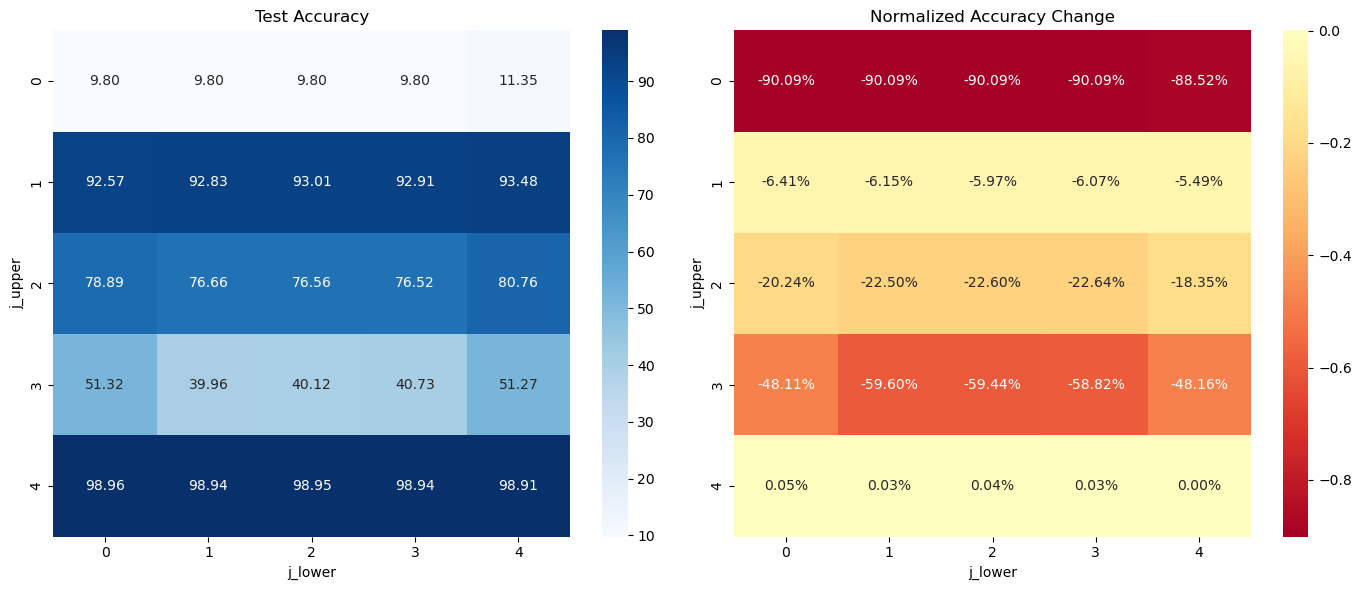


--- Summary for median ---
 jU  jL    Changed   %Changed   Accuracy
--------------------------------------------------
  0   0  1,199,881    100.00%      9.80%
  0   1  1,199,882    100.00%      9.80%
  0   2  1,199,879    100.00%      9.80%
  0   3  1,199,872    100.00%      9.80%
  0   4  1,199,868    100.00%     11.35%
  1   0  1,199,558     99.97%     92.57%
  1   1  1,199,178     99.94%     92.83%
  1   2  1,198,420     99.88%     93.01%
  1   3  1,197,023     99.76%     92.91%
  1   4  1,194,308     99.54%     93.48%
  2   0  1,192,600     99.39%     78.89%
  2   1  1,184,970     98.76%     76.66%
  2   2  1,169,332     97.45%     76.56%
  2   3  1,139,491     94.97%     76.52%
  2   4  1,081,140     90.10%     80.76%
  3   0  1,174,994     97.93%     51.32%
  3   1  1,108,315     92.37%     39.96%
  3   2  1,022,561     85.22%     40.12%
  3   3    863,300     71.95%     40.73%
  3   4    548,223     45.69%     51.27%
  4   0  1,151,386     95.96%     98.96%
  4   1  1,047,551 

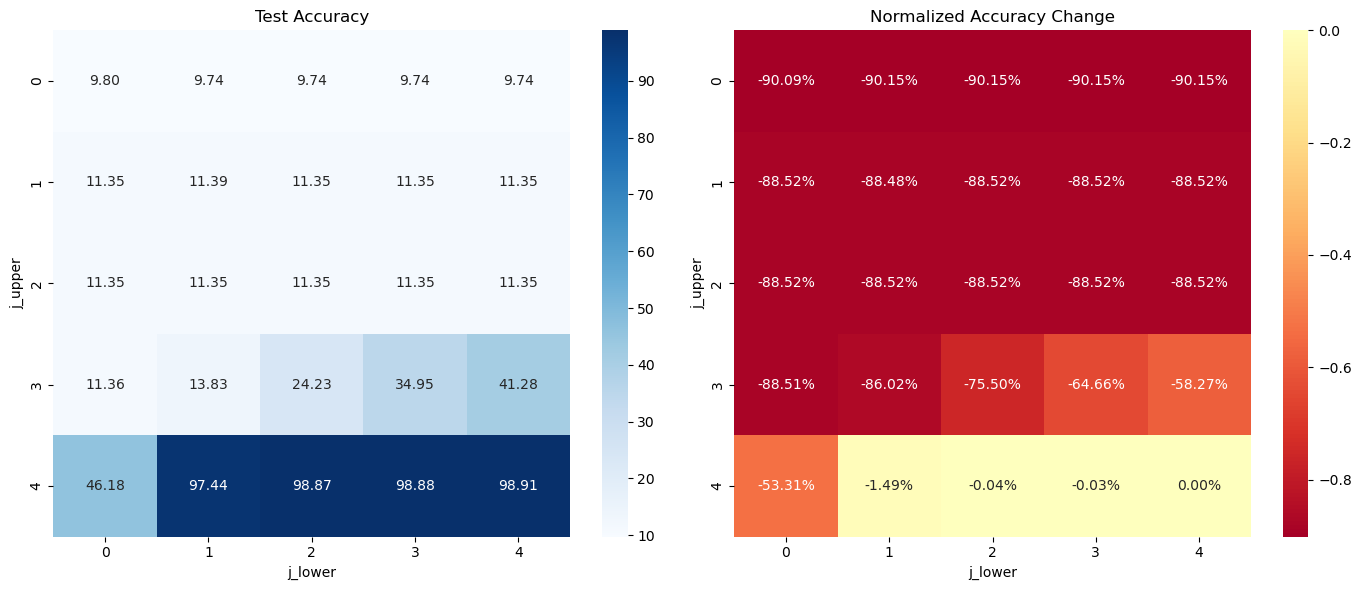


--- Summary for regular ---
 jU  jL    Changed   %Changed   Accuracy
--------------------------------------------------
  0   0  1,129,435     94.13%      9.80%
  0   1  1,113,434     92.80%      9.74%
  0   2  1,068,286     89.03%      9.74%
  0   3    972,531     81.05%      9.74%
  0   4    775,989     64.67%      9.74%
  1   0  1,129,435     94.13%     11.35%
  1   1  1,113,433     92.80%     11.39%
  1   2  1,068,285     89.03%     11.35%
  1   3    972,527     81.05%     11.35%
  1   4    775,975     64.67%     11.35%
  2   0  1,129,210     94.11%     11.35%
  2   1  1,112,884     92.75%     11.35%
  2   2  1,067,032     88.93%     11.35%
  2   3    969,812     80.83%     11.35%
  2   4    770,401     64.21%     11.35%
  3   0  1,123,603     93.64%     11.36%
  3   1  1,099,995     91.68%     13.83%
  3   2  1,039,231     86.61%     24.23%
  3   3    911,461     75.96%     34.95%
  3   4    651,659     54.31%     41.28%
  4   0  1,102,302     91.87%     46.18%
  4   1  1,053,806

In [18]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Main Experiment Logic
# ==============================

def main():
    print("=" * 60)
    print("MSB Sensitivity Sweep on Quantized Model (Half-Byte Version)")
    print("=" * 60)

    print("\n[1] Initializing Original Model...")
    total_params, _ = count_total_parameters(original_model)

    print("\n[2] Quantizing Model Weights to 8-bit...")
    with open('log.txt', 'w') as f:
        f.write("Quantizing Model Weights to 8-bit...\n")
    quantized_model, quant_params = quantize_model_weights(original_model)

    print("\n[3] Testing Quantized Model Without Perturbation")
    original_acc, _ = test_model(quantized_model, test_loader, model_name="Quantized No Perturbation")
    print(f"Original Quantized Accuracy: {original_acc:.2f}%")

    msb_functions = {
        "median": extract_half_signed_j_msb_median,
        "regular": extract_half_signed_j_msb
    }

    os.makedirs("results", exist_ok=True)

    for label, msb_function in msb_functions.items():
        print(f"\n[4-{label}] Sweeping MSB Levels using '{label}'")
        results = sweep_half_msb_levels(quantized_model, test_loader, quant_params, msb_function)

        print(f"\n--- Summary for {label} ---")
        print(f"{'jU':>3} {'jL':>3} {'Changed':>10} {'%Changed':>10} {'Accuracy':>10}")
        print("-" * 50)
        for r in results:
            pct = (r["num_changed"] / total_params) * 100
            print(f"{r['j_upper']:>3} {r['j_lower']:>3} {r['num_changed']:>10,d} {pct:>9.2f}% {r['accuracy']:>9.2f}%")

        # Save results to CSV
        csv_path = f"results/half_msb_results_{label}.csv"
        with open(csv_path, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=results[0].keys())
            writer.writeheader()
            writer.writerows(results)
        print(f"Saved CSV to {csv_path}")

        # Plot histograms
        hist_dir = f"results/weight_histograms_half_{label}"
        plot_half_weight_histograms(
            quantized_model, quant_params,
            msb_function=msb_function,
            output_dir=hist_dir,
            int8_mode=True
        )

if __name__ == "__main__":
    main()